# Code describe the line of reasoning we need to show for all the cases

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score

# Load data

In [2]:
B = pd.read_parquet('./data/B_HKML.parquet')

In [3]:
B = B[B['date'] < '2022-05-01']

In [4]:
B

,date,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,USFASTD_SOFTWARE,USFASTD_SPLTYRET,USFASTD_SPTYCHEM,USFASTD_SPTYSTOR,USFASTD_STREVRSL,USFASTD_TELECOM,USFASTD_TRADECO,USFASTD_TRANSPRT,USFASTD_VALUE,USFASTD_WIRELESS
0,2016-02-17,0.351,0.0,0.0,0.0,0.0,0.0,0.0,-0.335,0.0,...,0.0,0.0,0.000,0.0,-0.143,0.0,0.371,0.0,-0.083,0.0
1,2016-02-17,0.713,0.0,0.0,0.0,0.0,0.0,0.0,-0.699,0.0,...,0.0,0.0,0.000,0.0,-1.099,0.0,0.000,0.0,-0.051,0.0
2,2016-02-17,0.111,0.0,0.0,0.0,0.0,0.0,0.0,0.084,0.0,...,0.0,0.0,0.000,0.0,-0.020,0.0,0.000,0.0,-0.156,0.0
3,2016-02-17,0.314,0.0,0.0,0.0,0.0,0.0,0.0,0.105,0.0,...,0.0,0.0,0.000,0.0,-0.676,0.0,1.000,0.0,-0.682,0.0
4,2016-02-17,-0.130,1.0,0.0,0.0,0.0,0.0,0.0,-0.252,0.0,...,0.0,0.0,0.000,0.0,-0.552,0.0,0.000,0.0,-0.518,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310699,2022-04-27,-1.975,0.0,0.0,0.0,0.0,0.0,0.0,0.064,0.0,...,0.0,0.0,0.000,0.0,0.211,0.0,0.000,0.0,1.448,0.0
310700,2022-04-27,-0.140,0.0,0.0,0.0,0.0,0.0,0.0,-1.518,0.0,...,0.0,0.0,0.028,0.0,0.239,0.0,0.000,0.0,-0.317,0.0
310701,2022-04-27,0.690,0.0,0.0,0.0,0.0,0.0,0.0,-1.714,0.0,...,0.0,0.0,0.000,0.0,0.130,0.0,0.000,0.0,0.800,0.0
310702,2022-04-27,0.246,0.0,0.0,0.0,0.0,0.0,0.0,-0.953,0.0,...,0.0,0.0,0.000,0.0,-0.777,0.0,0.000,0.0,-0.006,0.0


In [5]:
X_df = pd.read_parquet('./data/XB_PCA_HKML.parquet')

In [6]:
X_df.reset_index(drop=True, inplace=True)

In [7]:
X_df = X_df[X_df['date'] < '2022-05-01']

In [8]:
y_df = pd.read_parquet('./data/Y_HKML.parquet')

In [9]:
y_df = y_df.iloc[X_df.index]

# Train-test split

In [10]:
moons = X_df.date.unique()

In [11]:
moon_train = moons[:230] 
moon_test = moons[260:]

# Define loss function

In [12]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

In [13]:
error_lis_mse = []
error_lis_orth = []
error_lis_combined = []
loss_mse = nn.MSELoss()

In [14]:
def custom_loss2(y_pred, y_true, b_moon):
    Omega = torch.eye(len(y_true)) - torch.mm(b_moon, torch.pinverse(b_moon))
    z_hat = torch.mm(Omega, y_pred)
    
    #error = torch.sum((z_hat - y_true)**2) / len(y_true)
    #error = torch.mm((z_hat - y_true).T, z_hat - y_true)/len(y_true)
    error = torch.linalg.norm(z_hat - y_true)/len(y_true)
    #error_lis.append(error)
    
    
    return error

In [15]:
def custom_loss3(y_pred, y_true, b_moon):
    #import pdb as pdb
    #pdb.set_trace()
    #error = error1 + error2
    error1 = loss_mse(y_pred, y_true) /len(y_true)
    error2 = loss_mse(torch.zeros(b_moon.shape[1],1), torch.mm(b_moon.T, y_pred))/len(y_true)
    error = error1 #+ error2 
    error_lis_mse.append(error1.item())
    error_lis_orth.append(error2.item())
    error_lis_combined.append(error.item())
    
    
    return error

# Train model and predict

In [16]:
# As this notebook shows a simple linear model, there is no need to introduce validation data, i.e. 
# the training is deterministic and only one epoch is necessary to perform it.
# Nevertheless, this section should train such that the validation loss is minimized.

In [17]:
class RegressionModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)
        #self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        hidden = self.fc1(x) # n*86, hidden.shape --> n*512
        relu_output = self.relu(hidden) 
        #dropout = self.dropout(relu_output)
        hidden2 = self.fc2(relu_output) # hidden2.shape --> n*512
        relu_output = self.relu(hidden2)
        #dropout = self.dropout(relu_output)
        y_pred = self.fc3(relu_output) # y_pred.shape --> n*1
        return y_pred

In [18]:
# Create an instance of the model
model = RegressionModel(input_size=177, hidden_size=512, output_size=1)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

# train model for 5 epochs using custom loss function
num_epochs = 10

In [19]:
for i in tqdm(range(num_epochs)):
    # print(f"Epoch {i+1}")
    # create minibatch of data
    #batch_size = 100
    for moon in moons[:230]:
        #pdb.set_trace()
        X_moon = torch.from_numpy(X_df[X_df.date == moon].drop(columns=["date"]).values).to(torch.float32)
        y_moon = torch.from_numpy(y_df[X_df.date == moon].values.reshape(-1,1)).to(torch.float32)

        b_moon = torch.from_numpy(B[X_df.date == moon].drop(columns=["date"]).values).to(torch.float32)
        y_pred = model(X_moon)
        loss = custom_loss3(y_pred, y_moon, b_moon)
        #loss = loss_mse(y_pred, y_moon)
        #error_lis.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print the loss every 100 epochs
    if (i + 1) % 1 == 0:
        print('Epoch [{}/{}], Loss: {:.10f}'.format(i+1, num_epochs, loss.item()))

 10%|█         | 1/10 [00:04<00:38,  4.26s/it]

Epoch [1/10], Loss: 0.0000031293


 20%|██        | 2/10 [00:08<00:32,  4.02s/it]

Epoch [2/10], Loss: 0.0000029808


 30%|███       | 3/10 [00:12<00:28,  4.02s/it]

Epoch [3/10], Loss: 0.0000028753


 40%|████      | 4/10 [00:16<00:24,  4.10s/it]

Epoch [4/10], Loss: 0.0000027919


 50%|█████     | 5/10 [00:20<00:20,  4.11s/it]

Epoch [5/10], Loss: 0.0000027139


 60%|██████    | 6/10 [00:24<00:16,  4.20s/it]

Epoch [6/10], Loss: 0.0000026331


 70%|███████   | 7/10 [00:29<00:12,  4.27s/it]

Epoch [7/10], Loss: 0.0000025468


 80%|████████  | 8/10 [00:33<00:08,  4.21s/it]

Epoch [8/10], Loss: 0.0000024633


 90%|█████████ | 9/10 [00:37<00:04,  4.17s/it]

Epoch [9/10], Loss: 0.0000023676


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

Epoch [10/10], Loss: 0.0000022615


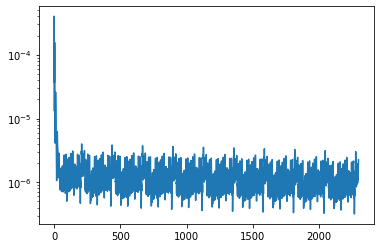

In [20]:
plt.semilogy(error_lis_mse)

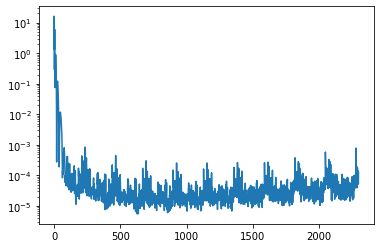

In [21]:
plt.semilogy(error_lis_orth)

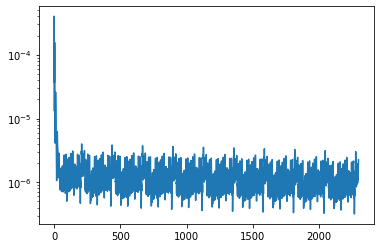

In [22]:
plt.semilogy(error_lis_combined)

In [23]:
epoch_loss = []
epoch_loss_mse = []
epoch_loss_orth = []
for i in range(num_epochs - 1):
    epoch_loss.append(sum(error_lis_combined[230*i:230*(i+1)]))
    epoch_loss_mse.append(sum(error_lis_mse[230*i:230*(i+1)]))
    epoch_loss_orth.append(sum(error_lis_mse[230*i:230*(i+1)]))

In [24]:
epoch_loss[0], epoch_loss_mse[0], epoch_loss_orth[0]

(0.001266330476511257, 0.001266330476511257, 0.001266330476511257)

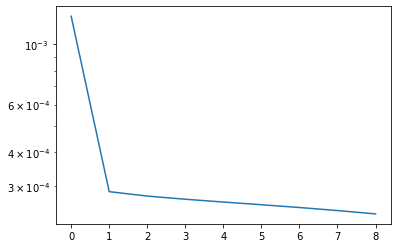

In [25]:
plt.semilogy(epoch_loss)

In [26]:
y_hat =  model(torch.from_numpy(X_df[X_df.date > moons[260]].drop(columns=["date"]).values).to(torch.float32)).detach().numpy()

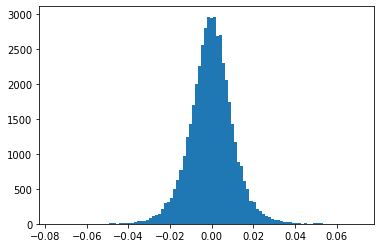

In [27]:
plt.hist(y_hat, bins=100)
plt.show()

In [28]:
y_test = y_df[X_df.date > moons[260]].values.reshape(-1,1)

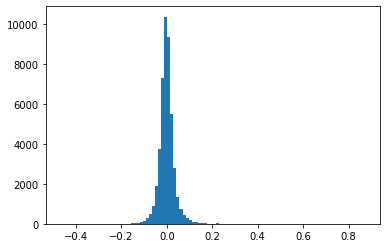

In [29]:
plt.hist(y_test, bins=100)
plt.show()

In [33]:
y_hat = y_hat.ravel()
y_test = y_test.ravel()

In [34]:
y_hat.shape, y_test.shape

((46376,), (46376,))

# Scatter plot to show linear relation between Y and y_hat

In [35]:
from scipy.stats import linregress

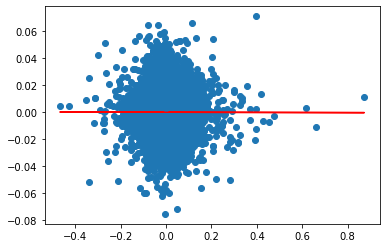

In [36]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_hat)
plt.scatter(y_test, y_hat)
plt.plot(y_test, slope * y_test + intercept,'r')
plt.show()

In [37]:
y_hat_df = pd.DataFrame()
y_hat_df['date'] = X_df[X_df['date'] > moons[260]].date
y_hat_df['y_hat'] = y_hat
y_hat_df['Y'] = y_test

In [38]:
y_hat_df # custom_fitenss

,date,y_hat,Y
264328,2021-06-16,-0.014018,-0.010859
264329,2021-06-16,0.027639,-0.036569
264330,2021-06-16,-0.021103,-0.005702
264331,2021-06-16,0.013848,-0.017353
264332,2021-06-16,-0.007365,-0.021563
...,...,...,...
310699,2022-04-27,-0.011314,0.020271
310700,2022-04-27,-0.003233,-0.023498
310701,2022-04-27,0.007323,0.007559
310702,2022-04-27,-0.011329,-0.006418


# Spearman

In [39]:
def spear(x):
    return x.corr(method='spearman').iloc[0, 1]

In [40]:
spearman = y_hat_df.groupby("date").apply(lambda x: spear(x))

/tmp/ipykernel_15786/710519440.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return x.corr(method='spearman').iloc[0, 1]


In [41]:
spearman.mean(), spearman.shape # 46 values for 46 moons

(0.005413994373631479, (46,))

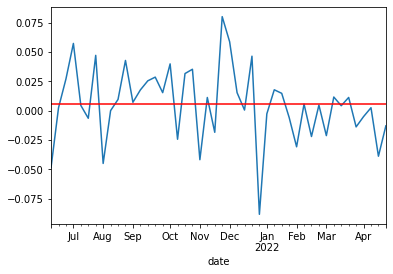

In [42]:
spearman.plot()
plt.axhline(y=spearman.mean(), color='r', linestyle='-')
plt.show()

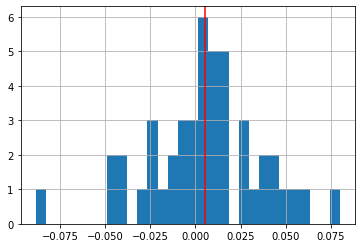

In [43]:
spearman.hist(bins=30)
plt.axvline(x=spearman.mean(), color='r', linestyle='-')

# MSE

In [44]:
mse = y_hat_df.groupby('date').apply(lambda x: mean_squared_error(x.y_hat, x.Y))

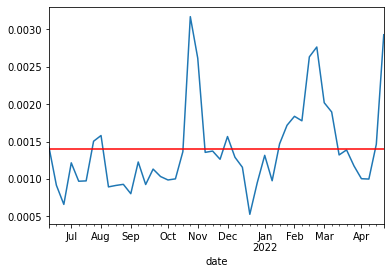

In [45]:
mse.plot()
plt.axhline(y=mse.mean(), color='r', linestyle='-')
plt.show()

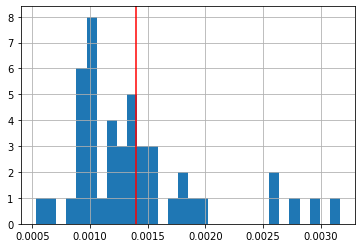

In [46]:
mse.hist(bins=30)
plt.axvline(x=mse.mean(), color='r', linestyle='-')

# Orthogonalize output and show same results.

In [47]:
B = B[X_df.date > moons[260]]

In [48]:
B

,date,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,USFASTD_SOFTWARE,USFASTD_SPLTYRET,USFASTD_SPTYCHEM,USFASTD_SPTYSTOR,USFASTD_STREVRSL,USFASTD_TELECOM,USFASTD_TRADECO,USFASTD_TRANSPRT,USFASTD_VALUE,USFASTD_WIRELESS
264328,2021-06-16,0.596,0.852,0.0,0.0,0.0,0.0,0.000,1.101,0.0,...,0.0,0.0,0.000,0.0,0.372,0.0,0.000,0.148,-1.258,0.0
264329,2021-06-16,-0.934,0.000,0.0,0.0,0.0,0.0,0.000,-0.048,0.0,...,0.0,0.0,0.000,0.0,-1.351,0.0,0.000,0.000,2.165,0.0
264330,2021-06-16,-0.119,0.000,0.0,0.0,0.0,0.0,0.000,-0.378,0.0,...,0.0,0.0,0.448,0.0,0.285,0.0,0.096,0.000,0.607,0.0
264331,2021-06-16,-0.519,0.000,0.0,0.0,0.0,0.0,0.000,0.662,0.0,...,0.0,0.0,0.000,0.0,-0.508,0.0,0.000,0.000,-0.261,0.0
264332,2021-06-16,0.504,0.000,0.0,0.0,0.0,0.0,0.012,1.319,0.0,...,0.0,0.0,0.000,0.0,-0.176,0.0,0.000,0.000,1.321,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310699,2022-04-27,-1.975,0.000,0.0,0.0,0.0,0.0,0.000,0.064,0.0,...,0.0,0.0,0.000,0.0,0.211,0.0,0.000,0.000,1.448,0.0
310700,2022-04-27,-0.140,0.000,0.0,0.0,0.0,0.0,0.000,-1.518,0.0,...,0.0,0.0,0.028,0.0,0.239,0.0,0.000,0.000,-0.317,0.0
310701,2022-04-27,0.690,0.000,0.0,0.0,0.0,0.0,0.000,-1.714,0.0,...,0.0,0.0,0.000,0.0,0.130,0.0,0.000,0.000,0.800,0.0
310702,2022-04-27,0.246,0.000,0.0,0.0,0.0,0.0,0.000,-0.953,0.0,...,0.0,0.0,0.000,0.0,-0.777,0.0,0.000,0.000,-0.006,0.0


In [49]:
y_hat_date = y_hat_df[['date', 'y_hat']] 

In [50]:
import sys
sys.path.insert(1, "../feature-engineering/src")
from class_ import Data

In [51]:
data = Data(f_matrix=y_hat_date, b_matrix=B)

In [52]:
data.orthogonalize()

  0%|          | 0/46 [00:00<?, ?it/s]

0

In [53]:
data.f_matrix

,date,y_hat
264328,2021-06-16,-0.007689
264329,2021-06-16,0.029729
264330,2021-06-16,-0.018560
264331,2021-06-16,0.016714
264332,2021-06-16,-0.005404
...,...,...
310699,2022-04-27,-0.013270
310700,2022-04-27,-0.006608
310701,2022-04-27,0.009350
310702,2022-04-27,-0.004882


In [54]:
y_hat_df.y_hat = data.f_matrix.y_hat

In [55]:
y_hat_df

,date,y_hat,Y
264328,2021-06-16,-0.007689,-0.010859
264329,2021-06-16,0.029729,-0.036569
264330,2021-06-16,-0.018560,-0.005702
264331,2021-06-16,0.016714,-0.017353
264332,2021-06-16,-0.005404,-0.021563
...,...,...,...
310699,2022-04-27,-0.013270,0.020271
310700,2022-04-27,-0.006608,-0.023498
310701,2022-04-27,0.009350,0.007559
310702,2022-04-27,-0.004882,-0.006418


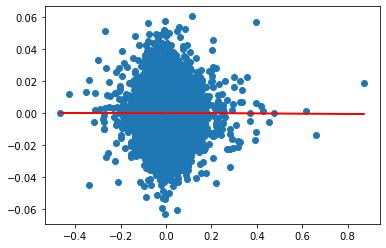

In [56]:
slope, intercept, r_value, p_value, std_err = linregress(y_hat_df.Y,y_hat_df.y_hat)
plt.scatter(y_hat_df.Y, y_hat_df.y_hat)
plt.plot(y_hat_df.Y, slope * y_hat_df.Y + intercept,'r')
plt.show()

/tmp/ipykernel_15613/710519440.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return x.corr(method='spearman').iloc[0, 1]


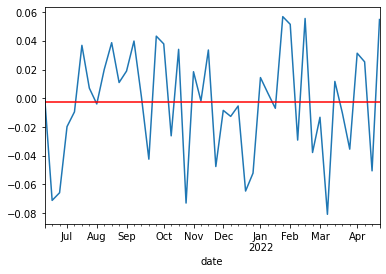

In [304]:
spearman = y_hat_df.groupby("date").apply(lambda x: spear(x))
spearman.plot()
plt.axhline(y=spearman.mean(), color='r', linestyle='-')
plt.show()

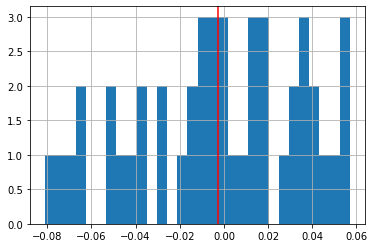

In [305]:
spearman.hist(bins=30)
plt.axvline(x=spearman.mean(), color='r', linestyle='-')

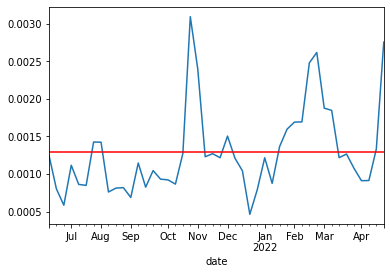

In [306]:
mse = y_hat_df.groupby('date').apply(lambda x: mean_squared_error(x.y_hat, x.Y))
mse.plot()
plt.axhline(y=mse.mean(), color='r', linestyle='-')
plt.show()

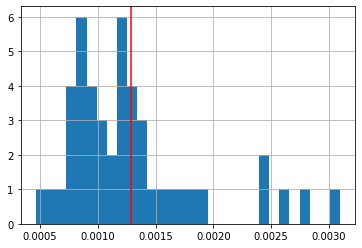

In [307]:
mse.hist(bins=30)
plt.axvline(x=mse.mean(), color='r', linestyle='-')